### Importing the necessary libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
#conda install -c anaconda joblib
from joblib import dump, load

import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Loading the Dataset and Adding headers

In [2]:
e_data = pd.read_csv("ratings_Electronics.csv",names=['UserId', 'ProductId','Rating','Timestamp'])

In [3]:
e_data.head()

,UserId,ProductId,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Shape of the data
e_data.shape

(7824482, 4)

In [5]:
#Taking subset of the dataset
e_data=e_data.iloc[:1048576,0:]

In [6]:
e_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   UserId     1048576 non-null  object 
 1   ProductId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   Timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [7]:
#Five point summary 
e_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [8]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(e_data.Rating.min()))
print('Maximum rating is: %d' %(e_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [9]:
#Handling Missing values
print('Number of missing values across columns: \n',e_data.isnull().sum())

Number of missing values across columns: 
 UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


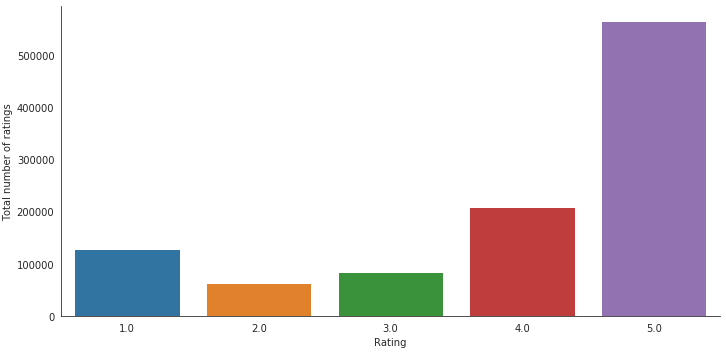

In [10]:
#Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=e_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

**Unique Users and products**

In [11]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",e_data.shape[0])
print("Total No of Users   :", len(np.unique(e_data.UserId)))
print("Total No of products  :", len(np.unique(e_data.ProductId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


**Dropping the TimeStamp Column**

In [12]:
e_data.drop(['Timestamp'], axis=1,inplace=True)

**Analyzing the rating given by the user**

In [13]:
no_of_rated_products_per_user = e_data.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

UserId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [14]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [15]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

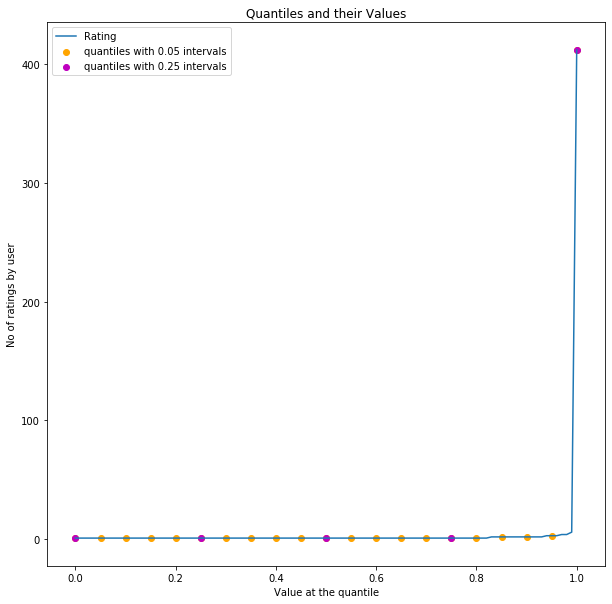

In [16]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [17]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



### Popularity Based Recommendation

In [18]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=e_data.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

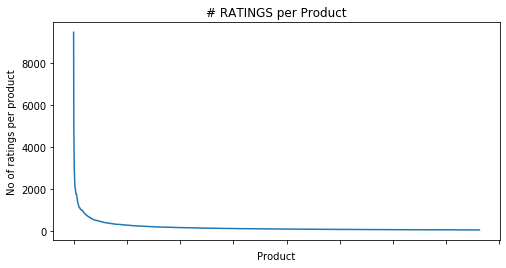

In [19]:
no_of_ratings_per_product = new_df.groupby(by='ProductId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [20]:
#Average rating of the product 
new_df.groupby('ProductId')['Rating'].mean().head()

ProductId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [21]:
new_df.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()

ProductId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [22]:
#Total no of rating for product
new_df.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()

ProductId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [23]:
ratings_mean_count = pd.DataFrame(new_df.groupby('ProductId')['Rating'].mean())

In [24]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('ProductId')['Rating'].count())

In [25]:
ratings_mean_count.head()

,Rating,rating_counts
ProductId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [26]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

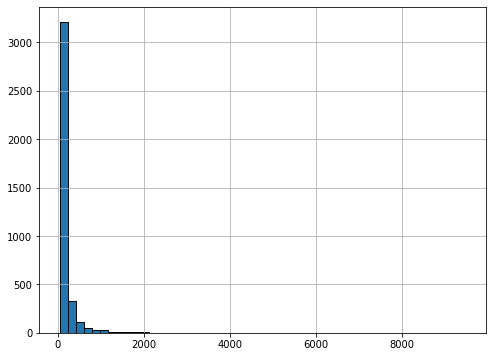

In [27]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

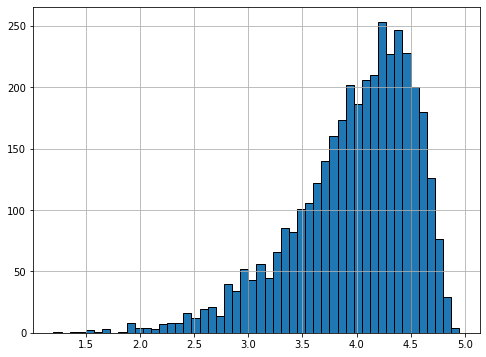

In [28]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

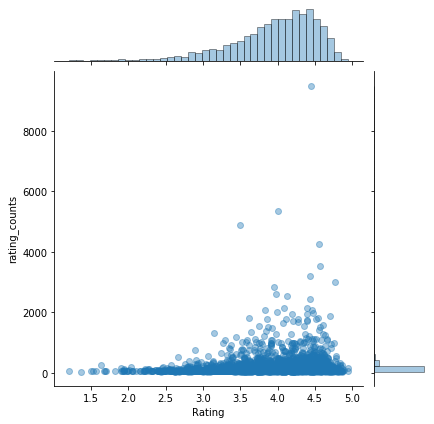

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

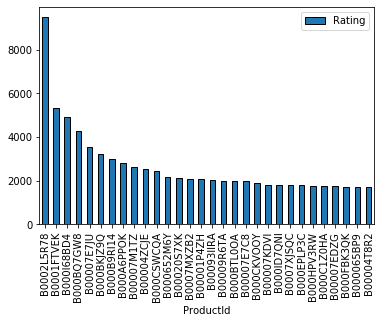

In [30]:
popular_products = pd.DataFrame(new_df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

**Popularity based recommendation gives same recommendation to all. It ignores user preference or choices. It might be good for some new user who does not specify prefrences. But not much can be done in this.**

### Collaberative filtering (Item-Item recommedation)

In [31]:
#conda install -c conda-forge scikit-surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [32]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [33]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [34]:
#Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [35]:
#run the trained model against the testset
test_pred = algo.test(testset)

In [36]:
test_pred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [37]:
#get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

### Model-based collaborative filtering system

In [38]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_matrix.head()

ProductId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
UserId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [39]:
ratings_matrix.shape

(9832, 76)

Transposing the matrix

In [40]:
X = ratings_matrix.T
X.head()

UserId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
ProductId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X.shape

(76, 9832)

**Unique products in subset of data**

In [42]:
X1 = X

In [43]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [44]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [45]:
X.index[75]

'B00000K135'

Index # of product ID purchased by customer

In [46]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [47]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 25 highly correlated products in sequence

In [48]:
Recommend = list(X.index[correlation_product_ID > 0.65])

#Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['8862935293',
 '9573212919',
 '9575871979',
 '9625993428',
 '9888002198',
 '9966694544',
 '9983891212',
 'B00000J1EP',
 'B00000JYWQ']

**Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website**

### Method 2

In [49]:
#The following code is to load data from Pandas DataFrame and create a SVD model instance:
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate
reader = Reader()
data = Dataset.load_from_df(new_df[['UserId', 'ProductId', 'Rating']], reader)
svd = SVD()

In [50]:
#Once the data and model for product recommendation are ready, the model can be evaluated using cross-validation as follows:
#Run 5-fold cross-validation and print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2658  1.2725  1.2730  1.2730  1.2679  1.2705  0.0030  
MAE (testset)     0.9942  0.9999  1.0008  0.9989  0.9958  0.9979  0.0025  
Fit time          80.55   80.87   80.66   80.92   81.18   80.84   0.22    
Test time         1.90    2.18    2.15    2.46    2.46    2.23    0.21    


{'test_rmse': array([1.26579034, 1.27251828, 1.27302677, 1.27303   , 1.26793491]),
 'test_mae': array([0.99423049, 0.99988078, 1.00083098, 0.99885344, 0.99580531]),
 'fit_time': (80.55398321151733,
  80.86679935455322,
  80.66338777542114,
  80.92023873329163,
  81.17772054672241),
 'test_time': (1.899125099182129,
  2.1757278442382812,
  2.1517086029052734,
  2.459428548812866,
  2.464688539505005)}

In [51]:
#Once the model has been evaluated to our satisfaction, then we can re-train the model using the entire training dataset:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [52]:
#After a recommendation model has been trained appropriately, it can be used for prediction.
#For example, given a user (e.g., User Id AWVFSIB42LHKJ), we can use the trained model to predict the ratings given by the user on different products (i.e., Product ID's):
#Recommending Products
rProducts = new_df.copy()
rProducts['Estimated_Ratings'] = rProducts['ProductId'].apply(lambda x: svd.predict('AWVFSIB42LHKJ', x).est)

In [53]:
#To recommend products to the given user, we can sort the list of Product Id in decreasing order of predicted ratings and take the top N Product Id as recommendations:
rProducts = rProducts.sort_values(by=['Estimated_Ratings'], ascending=False)
rProducts.head(5)

,UserId,ProductId,Rating,Estimated_Ratings
644110,A1G0CZ2N3IMG7P,B00081NX5U,4.0,4.991449
644166,A3V3TUYKTACW0Y,B00081NX5U,4.0,4.991449
644158,AYA4ZRSBGMRP5,B00081NX5U,5.0,4.991449
644159,A277LJO8YPC46E,B00081NX5U,4.0,4.991449
644160,A3LSYCZY6EB1NV,B00081NX5U,5.0,4.991449


**Here are the top 5 products to be recommended to the user with User Id AWVFSIB42LHKJ**

**Collaborative Filtering provides strong predictive power for recommender systems, and requires the least information at the same time. However, it has a few limitations in some particular situations.**

**With every type of recommender algorithm having its own list of pros and cons, it’s usually a hybrid recommender that comes to the rescue. The benefits of multiple algorithms working together or in a pipeline can help you set up more accurate recommenders.**